<a href="https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/notebooks/W266Multi%2BBinary_CK_11_22_BruteForce_nolexical120000trn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Set up 

In this notebook 
a ) I am using data from GCS, from courtney which is cleaned for age and other additional columns , 
b) I am also removing AGE from the model and lower string transformations
c) cleaning up the notebook for only model as of now

In [1]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Nov 29 02:08:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# imports
import sys
import csv

#import unidecode 
#import unicodedata
import pandas as pd
import io
from io import BytesIO
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import textwrap
import re
import time

In [3]:
!pip install transformers
import os, re
import time
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import io
from io import BytesIO
from transformers import AutoTokenizer, TFAutoModel
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,recall_score, precision_score, f1_score,matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.6 MB/s 
     |████████████████████████████████| 7.6 MB 83.3 MB/s 
     |████████████████████████████████| 182 kB 85.8 MB/s 


In [4]:
#imports and installs for feature engineering
!pip install empath
from empath import Empath
lexicon = Empath()
# Import module
!pip install NRCLex
from nrclex import NRCLex
import nltk
nltk.download('punkt')
import collections
from collections import Counter
import spacy
nlp =spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 3.0 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57822 sha256=3568b1aa77b74b75e1faec7603d2b3f9b82bc8aa8d0d5aabda32e200c31421dd
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 396 kB 4.7 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=88c073e4c3019aba92819a095c63111bfdcca854638c6d9fe937c0e1ac90759b
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# To work from gcloud, use this:

# Upload Google Cloud service account key to enable authentication ( json file )
# Go to https://console.cloud.google.com/:
# Under the Navigation Menu ( upper left 3 horizontal lines) 
# 1. choose IAM & Admin>
# 2. choose Service Accounts>
# 3. Select a Service Account>
# 4. Under the Actions menu ( 3 dots to the right of the service account )>Manage Keys to create your own json credentials file

from google.colab import files
from google.cloud import storage


def upload_gcloud_credentials():
    uploaded = files.upload()



def config_GCloud():
    #Load Google Cloud storage client using service key
    storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')
    #Print buckets available
    for bucket in storage_client.list_buckets():
        print(bucket)

    #Assign bucket name being used
    gcloud_bucket_name = '266csffile'

    #Get bucket
    gcloud_bucket = storage_client.get_bucket(gcloud_bucket_name)

    #Show list of files in bucket and list the files
    filename = list(gcloud_bucket.list_blobs(prefix=''))
    for name in filename:
        print(name.name)

    #Increase field size to allow reading in of files
    maxInt = sys.maxsize

    while True:
        # decrease the maxInt value by factor 10 as long as overflow error occurs 
        try:
            csv.field_size_limit(maxInt)
            break
        except OverflowError:
            maxInt = int(maxInt/10)

 
    return gcloud_bucket, gcloud_bucket_name


In [6]:
upload_gcloud_credentials()

Saving pacific-castle-360400-a3ca89f64de6.json to pacific-castle-360400-a3ca89f64de6.json


In [7]:
bucket, bucket_name = config_GCloud()

<Bucket: 266csffile>
<Bucket: w266liwc>
dev_is_I_data.parquet
dev_is_I_labels.parquet
dev_is_J_data.parquet
dev_is_J_labels.parquet
dev_is_S_data.parquet
dev_is_S_labels.parquet
dev_is_T_data.parquet
dev_is_T_labels.parquet
dev_mbti_data.parquet
dev_mbti_labels.parquet
mrc2.dct.textClipping
old_files/
old_files/dev_mbti_data.csv
old_files/dev_mbti_data.parquet
old_files/dev_mbti_labels.csv
old_files/test_mbti_data.csv
old_files/test_mbti_data.parquet
old_files/test_mbti_labels.csv
old_files/train_gen_pop_mbti_data.csv
old_files/train_gen_pop_mbti_data.parquet
old_files/train_gen_pop_mbti_labels.csv
old_files/train_mbti_data.csv
old_files/train_mbti_data.parquet
old_files/train_mbti_labels.csv
old_files/train_over_sampled_mbti_data.csv
old_files/train_over_sampled_mbti_data.parquet
old_files/train_over_sampled_mbti_labels.csv
old_files/train_under_sampled_mbti_data.csv
old_files/train_under_sampled_mbti_data.parquet
old_files/train_under_sampled_mbti_labels.csv
test_is_I_data.parquet
te

In [8]:
bert_model_name='bert-base-cased'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = TFAutoModel.from_pretrained(bert_model_name)
#bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_model.trainable = False



Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# Data Prep Training and Validation

In [9]:
# max_length=500
#increasing max length by 250 to accomodate additional tags and user info
max_length = 750
batch_size = 32

In [47]:
# setup google drive access for checkpoint file

from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive"
!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 001.jpg
'1) Nature of the Data Elements Breach....gdoc'
 20221028_213728.jpg
'2.4.22 Clark_John 2022 Partner Confirmation Statement.zip'
 326.pdf
 67956343.PDF
'Account QuickReport.xlsx'
'antrim_michigan_forensics_report_[121320]_v2_[redacted].pdf'
'ATC Security Job Description.gdoc'
 bert_multibinary_1120.hdf5
'BSN 181 Hawaii.docx.gdoc'
 b-whitepaper_best_practices_endpoint_dlp-01-2009.en-us.pdf
 b-whitepaper_dlp_content_discovery_best_practices_01_2009.en-us.pdf
 b-whitepaper_ponemon_symc_data_loss_risks_during_downsizing_02-2009.en-us.pdf
 b-whitepaper_vontu__3_steps_to_protect_confidential_data_on_laptops_01_2009.en-us.pdf
'Clark 140502cl Engagement Letter.pdf'
'Clark 9 25.PDF'
'Clark AA.pdf'
 Clark.gdoc
'Clark morningstars.pdf'
 Clark.pdf
'Colab Notebooks'
 connection-min.js
'Copy of Managed Services Contract for: Typology Central.gdoc'
 cron.php
'css(1

In [48]:
# Checkpoint configurations on google drive 

checkpoint_dir = 'drive/MyDrive/'
#checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint_filepath = checkpoint_dir + 'bert_multibinary_1129.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    #save_freq =100*batch_size
    )

In [12]:
def read_parquet_google_cloud(file):
    '''This function reads a file from the google cloud storage bucket. Input
    parameters include the filename, encoding and CSV file separators.'''

    #Load Google Cloud storage client using service key

    blob = bucket.blob(file)
    read_back = bucket.blob(file)
    string_read_back = read_back.download_as_string()
    new_df = pd.read_parquet(io.BytesIO(string_read_back))

    return new_df

In [13]:
def combine_no_username(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"lexical categories: "+df['lexicon'].astype(str)+ " [SEP] "+"emotion scores: "+df['emotions'].astype(str)+" [SEP] " + "pos tags: "+df['postags'].astype(str)+ " [SEP] " + df['message'].astype(str)
    return df

def combine_no_emotion(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = df['Username'].astype(str)+" [SEP] " + df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"lexical categories: "+df['lexicon'].astype(str)+ " [SEP] "+ "pos tags: "+df['postags'].astype(str)+ " [SEP] " + df['message'].astype(str)
    return df


def combine_no_lexical(df):
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = df['Username'].astype(str)+" [SEP] " + df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"emotion scores: "+df['emotions'].astype(str)+" [SEP] " + "pos tags: "+df['postags'].astype(str)+ " [SEP] " + df['message'].astype(str)
    return df

def combine_no_pos(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
 
    df['combined'] = df['Username'].astype(str)+" [SEP] " + df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"lexical categories: "+df['lexicon'].astype(str)+ " [SEP] "+"emotion scores: "+df['emotions'].astype(str)+" [SEP] " + df['message'].astype(str)
    return df


def combine_all(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = df['Username'].astype(str)+" [SEP] " + df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"lexical categories: "+df['lexicon'].astype(str)+ " [SEP] "+"emotion scores: "+df['emotions'].astype(str)+" [SEP] " + "pos tags: "+df['postags'].astype(str)+ " [SEP] " + df['message'].astype(str)
    return df


def add_features(df):
    # first remove Username
    return combine_no_lexical(df)
    

In [14]:
train_mbti_data = read_parquet_google_cloud('train_uniform_mbti_data.parquet')
train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')
#remove gender from the train data set
train_mbti_data = train_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]
#train_mbti_data, train_mbti_labels = train_mbti_data[120000:130000], train_mbti_labels[120000:130000]
#train_mbti_data, train_mbti_labels = train_mbti_data[:40000], train_mbti_labels[:40000]
#train_mbti_data = add_features(train_mbti_data)

dev_mbti_data = read_parquet_google_cloud('dev_mbti_data.parquet')
dev_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')
#dev_mbti_data, dev_mbti_labels = dev_mbti_data[:2000], dev_mbti_labels[:2000]
#remove gender from the dev data set 
dev_mbti_data = dev_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

In [15]:
train_mbti_data.count()

Username      1200000
Age           1200000
Posts         1200000
Occupation     623662
message       1200000
is_I          1200000
is_S          1200000
is_T          1200000
is_J          1200000
dtype: int64

In [16]:
train_mbti_data

,Username,Age,Posts,Occupation,message,is_I,is_S,is_T,is_J
0,oneandonly,37.0,109,None,i do not think i am at all. but the question...,True,False,False,True
1,thalassa,45.0,25183,tree people,YYY0 of the longest threads on this site con...,True,True,False,False
2,lady_x,46.0,18233,photographer,XXXX seems right..i would guess t/f were balan...,False,False,False,False
3,eagle,31.0,733,student,i noticed. it is hard to care over such a gr...,True,True,True,True
4,ayoitsstepho,31.0,4838,painter,:hug:,True,True,False,False
...,...,...,...,...,...,...,...,...,...
1199995,badoctopus,37.0,3234,None,no.,True,False,True,True
1199996,agentf,45.0,1543,î”,i feel like a size YYYYYY fat disgusting pig. ...,False,False,False,False
1199997,uumlau,56.0,5517,None,because it is a bone,True,False,True,True
1199998,taito,32.0,5965,None,"as opposed to what, YYYchanning it? is that ...",True,True,True,False


In [17]:
train_mbti_data.isna().any()

Username      False
Age           False
Posts         False
Occupation     True
message       False
is_I          False
is_S          False
is_T          False
is_J          False
dtype: bool

In [18]:
train_mbti_data.isnull().any()

Username      False
Age           False
Posts         False
Occupation     True
message       False
is_I          False
is_S          False
is_T          False
is_J          False
dtype: bool

Question 1 Should we be handling null occupations any diffrent

In [19]:
train_mbti_labels

,original index,MBTI Type
0,1007549,INFJ
1,1423561,ISFP
2,828282,ENFP
3,351444,ISTJ
4,121940,ISFP
...,...,...
1199995,134342,INTJ
1199996,14287,ENFP
1199997,1523769,INTJ
1199998,1387387,ISTP


In [20]:
#Create dictonary to transform MBTI type into multiclass value from 0 to 15
valid_MBTI = {'ISTJ': 0, 'INTJ': 1, 'ESTJ': 2, 'ENTJ': 3, 'ENTP': 4, 'INTP': 5, \
              'ISTP': 6, 'ESTP': 7, 'ISFJ': 8, 'INFJ': 9, 'ESFJ': 10, \
              'ENFJ': 11, 'ENFP': 12, 'INFP': 13, 'ISFP': 14, 'ESFP': 15}

In [21]:
ie ={'Introvert': True,'Extrovert':False}
si ={'Sensing': True,'Intution':False}
thinkfeel ={'Thinking': True,'Feeling':False}
jp ={'Judging': True,'Perceiving':False}

In [22]:
def preprocess_data(message,labels,labels_ie,labels_si,labels_tf,labels_jp,tokenizer,max_length=750):


    encodings = tokenizer(message,truncation=True,max_length=max_length,
                          padding='max_length',return_attention_mask=True,
                          return_token_type_ids=True, return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    input_ids = np.array(encodings["input_ids"], dtype="int32")
    attention_masks = np.array(encodings["attention_mask"], dtype="int32")
    token_type_ids = np.array(encodings["token_type_ids"], dtype="int32")
    np_labels = np.asarray(labels)
    # additional labels for binary classification model trainings
    np_labels_ie = np.asarray(labels_ie)
    np_labels_si = np.asarray(labels_si)
    np_labels_tf = np.asarray(labels_tf)
    np_labels_jp = np.asarray(labels_jp)
    return [input_ids,attention_masks,token_type_ids], [np_labels,np_labels_ie,np_labels_si,np_labels_tf,np_labels_jp]

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class MBTIDataGenerator(tf.keras.utils.Sequence): 
    def __init__(self,
                 tokenizer,
                 n_examples,
                 df_train,
                 df_labels,
                 max_length=750,
                 batch_size=32,
                 shuffle=True):
        
        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.df_train = df_train
        self.df_labels = df_labels
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()
    
    def __len__(self):
        # NOTE: USING REDUCED BATCHES PER EPOCH TO SPEED UP THE LIVE DEMO
        # For normal use, this line should be:
        return self.n_examples // self.batch_size
        #return 1500
    
    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        processing_df = self.df_train.iloc[batch_start:batch_end][['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

        features_df = add_features(processing_df)

        message = features_df['combined'].values.astype(str).tolist()
        
        labels = self.df_labels.iloc[batch_start:batch_end]['MBTI Type'].map(valid_MBTI).values.tolist()

        labels_ie = self.df_train.iloc[batch_start:batch_end]['is_I'].values.tolist()

        labels_si = self.df_train.iloc[batch_start:batch_end]['is_S'].values.tolist()

        labels_tf = self.df_train.iloc[batch_start:batch_end]['is_T'].values.tolist()

        labels_jp = self.df_train.iloc[batch_start:batch_end]['is_J'].values.tolist()
        
        batch_data = preprocess_data(
            message,
            labels,
            labels_ie,
            labels_si,
            labels_tf,
            labels_jp,
            self.tokenizer,
            self.max_length
        )

        return batch_data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [24]:
train_data_generator = MBTIDataGenerator(
    tokenizer=bert_tokenizer,
    n_examples=1200000,
#    n_examples=60000,
    df_train=train_mbti_data,
    df_labels=train_mbti_labels,
    max_length=750,
    batch_size=32
)

In [25]:
dev_data_generator = MBTIDataGenerator(
    tokenizer=bert_tokenizer,
    n_examples=200000,
#    n_examples=7200,
    df_train=dev_mbti_data,
    df_labels=dev_mbti_labels,
    max_length=750,
    batch_size=32
)

In [26]:
train_mbti_data

,Username,Age,Posts,Occupation,message,is_I,is_S,is_T,is_J
0,oneandonly,37.0,109,None,i do not think i am at all. but the question...,True,False,False,True
1,thalassa,45.0,25183,tree people,YYY0 of the longest threads on this site con...,True,True,False,False
2,lady_x,46.0,18233,photographer,XXXX seems right..i would guess t/f were balan...,False,False,False,False
3,eagle,31.0,733,student,i noticed. it is hard to care over such a gr...,True,True,True,True
4,ayoitsstepho,31.0,4838,painter,:hug:,True,True,False,False
...,...,...,...,...,...,...,...,...,...
1199995,badoctopus,37.0,3234,None,no.,True,False,True,True
1199996,agentf,45.0,1543,î”,i feel like a size YYYYYY fat disgusting pig. ...,False,False,False,False
1199997,uumlau,56.0,5517,None,because it is a bone,True,False,True,True
1199998,taito,32.0,5965,None,"as opposed to what, YYYchanning it? is that ...",True,True,True,False


In [27]:
dev_data_generator[0]

([array([[  101,   170,  3361, ...,     0,     0,     0],
         [  101,  1894,  5628, ...,     0,     0,     0],
         [  101,  1115,  1116, ...,     0,     0,     0],
         ...,
         [  101,  1821,  1813, ...,     0,     0,     0],
         [  101,   178,  7170, ...,     0,     0,     0],
         [  101,  2003, 20695, ...,     0,     0,     0]], dtype=int32),
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32)],
 [array([ 5, 15,  5,  5,  4, 10,  1,  5, 14, 15, 13, 11,  1,  5,  1,  3,  6,
         10,  4,  4, 13, 13,  5, 11,  5,  5,  3,  5,  3, 12, 13,  0]),
  array(

In [28]:
train_data_generator[0]

([array([[  101,  1141,  5709, ...,     0,     0,     0],
         [  101, 24438,  5971, ...,     0,     0,     0],
         [  101,  5141,   168, ...,     0,     0,     0],
         ...,
         [  101,   187,  1320, ...,     0,     0,     0],
         [  101,  1344, 21077, ...,     0,     0,     0],
         [  101,  2003, 20695, ...,     0,     0,     0]], dtype=int32),
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32)],
 [array([ 9, 14, 12,  0, 14,  7, 14,  0, 10,  6, 13,  4,  8,  3, 14, 11,  9,
         13,  8,  0, 10,  7,  4, 15,  3, 10,  1, 13, 14,  3,  1,  0]),
  array(

# Set up test and document the run

In [29]:
results_dict={}

In [77]:
test_mbti_data = read_parquet_google_cloud('test_mbti_data.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')


In [78]:
test_mbti_data.shape

(93106, 16)

In [79]:
train_mbti_data = train_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

In [80]:
test_mbti_data.count()

original index         93106
Username               93106
Age                    93106
Posts                  93106
Enneagram              71461
Instinctual Variant    48564
Gender                 50522
Occupation             49765
is_I                   93106
is_S                   93106
is_T                   93106
is_J                   93106
post_id                93106
thread_id              93106
post_date              93106
message                93106
dtype: int64

In [81]:
test_mbti_data, test_mbti_labels = test_mbti_data[:93000], test_mbti_labels[:93000]


In [82]:
test_mbti_data.shape

(93000, 16)

In [83]:
 test_mbti_data = add_features(test_mbti_data)

In [84]:
test_mbti_data.shape

(93000, 19)

In [85]:
test_mbti_data

,original index,Username,Age,Posts,Enneagram,Instinctual Variant,Gender,Occupation,is_I,is_S,is_T,is_J,post_id,thread_id,post_date,message,emotions,postags,combined
1400000,852132,laurie,49.0,6072,7w6,None,None,nada,False,False,False,False,638492,16494,1241329093,i liked it.,,"pron 2, verb 1, punct 1",laurie [SEP] 49.0 [SEP] 6072 [SEP] nada [SEP] ...
1400001,1242759,searchingforpeace,52.0,5569,9w8,sx_so,male,None,False,False,False,True,2915026,92831,1510500229,nope just why?,,"space 1, intj 1, adv 1, sconj 1, punct 1",searchingforpeace [SEP] 52.0 [SEP] 5569 [SEP] ...
1400002,61435,anonymous,33.0,605,5w6,None,None,None,True,False,True,False,231697,6377,1215135397,"heh, why n? he comes across as an enforcer o...","negative 2, sadness 1, disgust 1, fear 1","space 1, intj 1, punct 6, sconj 2, adv 4, pron...",anonymous [SEP] 33.0 [SEP] 605 [SEP] None [SEP...
1400003,437446,eric b,56.0,3620,548,sp_sx,None,subway motorman,True,False,True,False,2278060,69138,1397856258,^ i think so too!! tyrion and brienne are both...,"trust 4, positive 4, fear 4, negative 5, antic...","x 1, pron 12, verb 12, adv 10, punct 13, noun ...",eric b [SEP] 56.0 [SEP] 3620 [SEP] subway moto...
1400004,1589900,yama,28.0,7684,6w7,so_sx,male,microbiology technician,False,True,False,True,2892167,84507,1506426888,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,,"x 2, punct 1, adv 1, pron 1, verb 1, space 1",yama [SEP] 28.0 [SEP] 7684 [SEP] microbiology ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492995,329378,disregard,34.0,7826,None,None,None,receiving manager,True,False,False,False,196513,5335,1208929805,i really want some sake and a rainbow roll.,,"pron 1, adv 1, verb 1, det 2, noun 3, cconj 1,...",disregard [SEP] 34.0 [SEP] 7826 [SEP] receivin...
1492996,50487,amargith,41.0,14717,4dw,sx_so,female,consultant,False,False,False,False,2909399,92475,1509621044,today i am making chili and on the YYYYYYth i ...,"anticipation 2, joy 2, positive 2, trust 1","noun 13, pron 7, aux 5, verb 6, cconj 4, adp 3...",amargith [SEP] 41.0 [SEP] 14717 [SEP] consulta...
1492997,1537148,velvet_rose,32.0,14,4w5,None,None,None,True,False,False,False,2064259,2230,1365795072,i reread it and i agree. i considered XXXX ...,positive 1,"space 2, pron 6, verb 5, cconj 2, punct 4, nou...",velvet_rose [SEP] 32.0 [SEP] 14 [SEP] None [SE...
1492998,1054498,ptgatsby,43.0,4474,None,None,None,None,True,True,True,False,28835,1054,1184197728,a better analogy would probably be the justi...,"positive 8, trust 3, surprise 2, anger 2, fear...","space 7, det 16, adj 7, noun 29, aux 14, adv 1...",ptgatsby [SEP] 43.0 [SEP] 4474 [SEP] None [SEP...


In [86]:
test_combined = pd.concat([test_mbti_data,test_mbti_labels],axis=1)

In [87]:
test_combined

,original index,Username,Age,Posts,Enneagram,Instinctual Variant,Gender,Occupation,is_I,is_S,...,is_J,post_id,thread_id,post_date,message,emotions,postags,combined,original index,MBTI Type
1400000,852132,laurie,49.0,6072,7w6,None,None,nada,False,False,...,False,638492,16494,1241329093,i liked it.,,"pron 2, verb 1, punct 1",laurie [SEP] 49.0 [SEP] 6072 [SEP] nada [SEP] ...,852132,ENFP
1400001,1242759,searchingforpeace,52.0,5569,9w8,sx_so,male,None,False,False,...,True,2915026,92831,1510500229,nope just why?,,"space 1, intj 1, adv 1, sconj 1, punct 1",searchingforpeace [SEP] 52.0 [SEP] 5569 [SEP] ...,1242759,ENFJ
1400002,61435,anonymous,33.0,605,5w6,None,None,None,True,False,...,False,231697,6377,1215135397,"heh, why n? he comes across as an enforcer o...","negative 2, sadness 1, disgust 1, fear 1","space 1, intj 1, punct 6, sconj 2, adv 4, pron...",anonymous [SEP] 33.0 [SEP] 605 [SEP] None [SEP...,61435,INTP
1400003,437446,eric b,56.0,3620,548,sp_sx,None,subway motorman,True,False,...,False,2278060,69138,1397856258,^ i think so too!! tyrion and brienne are both...,"trust 4, positive 4, fear 4, negative 5, antic...","x 1, pron 12, verb 12, adv 10, punct 13, noun ...",eric b [SEP] 56.0 [SEP] 3620 [SEP] subway moto...,437446,INTP
1400004,1589900,yama,28.0,7684,6w7,so_sx,male,microbiology technician,False,True,...,True,2892167,84507,1506426888,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,,"x 2, punct 1, adv 1, pron 1, verb 1, space 1",yama [SEP] 28.0 [SEP] 7684 [SEP] microbiology ...,1589900,ESFJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492995,329378,disregard,34.0,7826,None,None,None,receiving manager,True,False,...,False,196513,5335,1208929805,i really want some sake and a rainbow roll.,,"pron 1, adv 1, verb 1, det 2, noun 3, cconj 1,...",disregard [SEP] 34.0 [SEP] 7826 [SEP] receivin...,329378,INFP
1492996,50487,amargith,41.0,14717,4dw,sx_so,female,consultant,False,False,...,False,2909399,92475,1509621044,today i am making chili and on the YYYYYYth i ...,"anticipation 2, joy 2, positive 2, trust 1","noun 13, pron 7, aux 5, verb 6, cconj 4, adp 3...",amargith [SEP] 41.0 [SEP] 14717 [SEP] consulta...,50487,ENFP
1492997,1537148,velvet_rose,32.0,14,4w5,None,None,None,True,False,...,False,2064259,2230,1365795072,i reread it and i agree. i considered XXXX ...,positive 1,"space 2, pron 6, verb 5, cconj 2, punct 4, nou...",velvet_rose [SEP] 32.0 [SEP] 14 [SEP] None [SE...,1537148,INFP
1492998,1054498,ptgatsby,43.0,4474,None,None,None,None,True,True,...,False,28835,1054,1184197728,a better analogy would probably be the justi...,"positive 8, trust 3, surprise 2, anger 2, fear...","space 7, det 16, adj 7, noun 29, aux 14, adv 1...",ptgatsby [SEP] 43.0 [SEP] 4474 [SEP] None [SEP...,1054498,ISTP


In [88]:

test_labels = test_mbti_labels['MBTI Type'].map(valid_MBTI).values.tolist()
#test_data_st = test_mbti_data['message'].values.astype(str).tolist()
test_data_st = test_mbti_data['combined'].values.astype(str).tolist()

# Generate encodings for dev and test
test_encodings = bert_tokenizer(test_data_st,truncation=True, max_length=max_length,padding='max_length',return_attention_mask=True,return_token_type_ids=True, return_tensors='tf')

nptest_labels = np.asarray(test_labels)

In [89]:
labels_ie = np.asarray(test_mbti_data['is_I'].values.tolist())
labels_si = np.asarray(test_mbti_data['is_S'].values.tolist())
labels_tf = np.asarray(test_mbti_data['is_T'].values.tolist())
labels_jp = np.asarray(test_mbti_data['is_J'].values.tolist())

# Multihead attention Model with Binary Classification

In [40]:
# this one is based on the multiheaded attention added 
def create_mbti_bert_mh_bin_model(bert_model,
                                hidden_size = 501, 
                                dropout=0.3,
                                learning_rate=0.00005,max_length=750):
    """
    Build a simple classification model with BERT. Add self attention layers on top of BERT output , training entire BERT is costly
    """

    input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
    token_type_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids')

  
    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    # multiclass classification for 16 different types of MBTI Types 
    sequence_output = bert_output.last_hidden_state
    # add additional self attention layers on the BERT Output 
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=250)(sequence_output, sequence_output)
    max_pool = layers.GlobalMaxPooling1D()(attn_output)
    dropout_output = layers.Dropout(0.3)(max_pool)
    # using softmax activation
    final_output = layers.Dense(16, activation="softmax",name='final_output')(dropout_output)
    # Binary classification for each of the  MBTI dimensions , evaluated using sigmoid activation
    # The inputs to the model remain the same, we need additional 4 outputs 
    # should we be doing additional dense layer and additional dropouts on them for binary
    
    # Introvert vs Extrovert
    binary_ie = layers.Dense(1,activation="sigmoid",name='binary_ie')(dropout_output)

    # Sensing vs Intuition
    binary_si = layers.Dense(1,activation="sigmoid",name='binary_si')(dropout_output)

    # Thinking vs Feeling
    binary_tf = layers.Dense(1,activation="sigmoid",name='binary_tf')(dropout_output)

    # Judging vs Perceiving
    binary_jp = layers.Dense(1,activation="sigmoid",name='binary_jp')(dropout_output)

    losses ={'final_output':keras.losses.SparseCategoricalCrossentropy(),
             'binary_ie':keras.losses.BinaryCrossentropy(),'binary_si':keras.losses.BinaryCrossentropy(),
             'binary_tf':keras.losses.BinaryCrossentropy(),'binary_jp':keras.losses.BinaryCrossentropy()}
        

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output,binary_ie,binary_si,binary_tf,binary_jp])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=losses,
                  metrics=['accuracy'])
    return model

 Question 2 : should we be doing additional dense layer and additional dropouts on them for binary ?

In [41]:
mbti_bert_mh_bin_model = create_mbti_bert_mh_bin_model(bert_model)

In [42]:
mbti_bert_mh_bin_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 750)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 750)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 750)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
checkpoint_dir = 'drive/MyDrive/model_checkpoints/'
#checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint_filepath = checkpoint_dir + 'bert_multibinary_1129.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    #save_freq =100*batch_size
    )
#mbti_bert_mh_bin_model.load_weights('/content/drive/MyDrive/bert_multibinary_1128.hdf5')

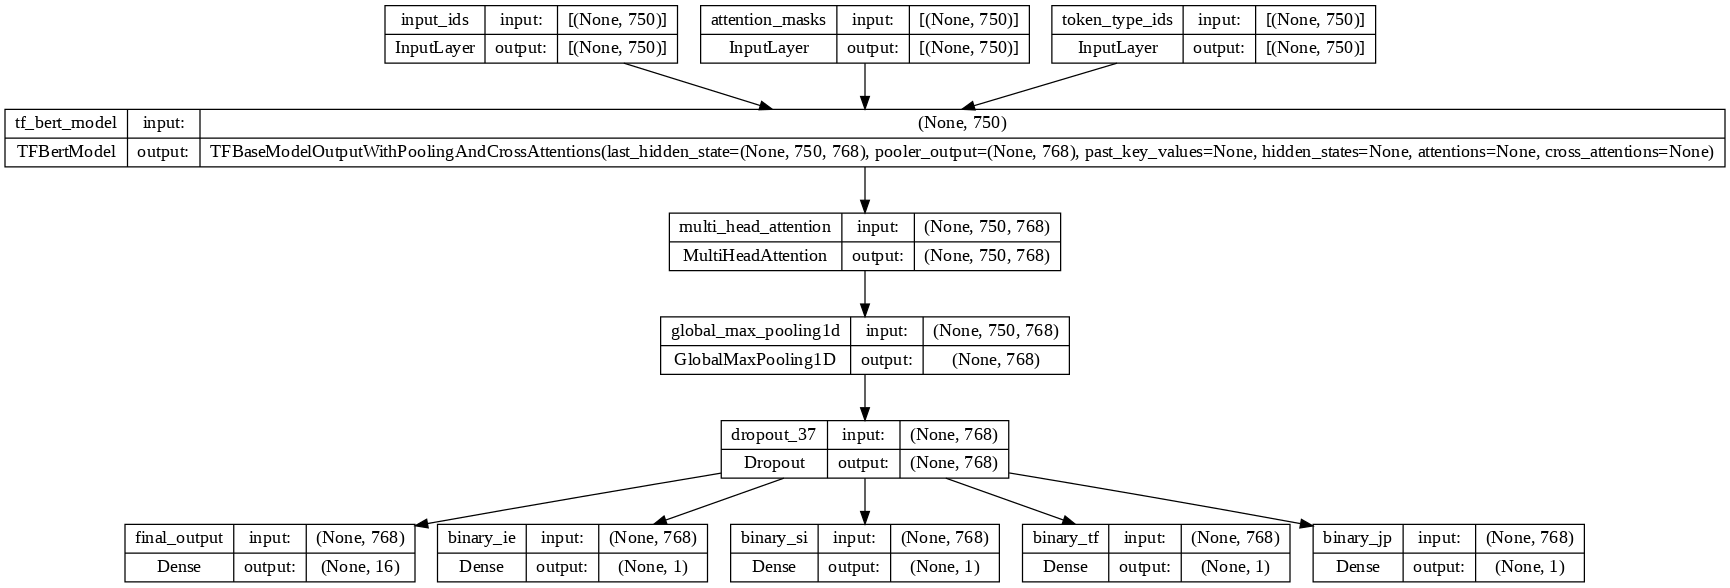

In [45]:
keras.utils.plot_model(mbti_bert_mh_bin_model, show_shapes=True, dpi=90)

In [49]:
mbti_bert_mh_bin_model_history = mbti_bert_mh_bin_model.fit(train_data_generator,    
                                                  validation_data=dev_data_generator,    
                                                  callbacks=[model_checkpoint_callback],
                                                  epochs=1)

37500/37500 [==============================] - 27368s 730ms/step - loss: 0.8602 - final_output_loss: 0.4773 - binary_ie_loss: 0.0944 - binary_si_loss: 0.0838 - binary_tf_loss: 0.1026 - binary_jp_loss: 0.1021 - final_output_accuracy: 0.9498 - binary_ie_accuracy: 0.9737 - binary_si_accuracy: 0.9777 - binary_tf_accuracy: 0.9696 - binary_jp_accuracy: 0.9701 - val_loss: 0.7667 - val_final_output_loss: 0.4858 - val_binary_ie_loss: 0.0605 - val_binary_si_loss: 0.0761 - val_binary_tf_loss: 0.0750 - val_binary_jp_loss: 0.0693 - val_final_output_accuracy: 0.9592 - val_binary_ie_accuracy: 0.9832 - val_binary_si_accuracy: 0.9801 - val_binary_tf_accuracy: 0.9797 - val_binary_jp_accuracy: 0.9815


In [90]:
from sklearn.metrics import confusion_matrix
def document_multimodel_run(model_type,mbti_model,target_names,ie,si,thinkfeel,jp,results_dict,input_ids,token_type_ids,attention_mask,nptest_labels,labels_ie,labels_si,labels_tf,labels_jp):

  # score = mbti_model.evaluate([input_ids,token_type_ids,attention_mask],nptest_labels) 
  # print('Test loss:', score[0]) 
  # print('Test accuracy:', score[1])
  # Get Entire Predictions
  predictions = mbti_model.predict([input_ids,token_type_ids,attention_mask])

  
  multiclass_predictions = np.argmax(predictions[0],axis=-1)


  b_ie = np.array(predictions[1] > 0.5,dtype=bool)
  b_si = np.array(predictions[2] > 0.5,dtype=bool)
  b_tf = np.array(predictions[3] > 0.5,dtype=bool)
  b_jp = np.array(predictions[4] > 0.5,dtype=bool)

  #Multiclass classification
  print(classification_report(nptest_labels, multiclass_predictions,target_names=target_names))

  cr_multi = classification_report(nptest_labels, multiclass_predictions, target_names=target_names)

  cm_multi = confusion_matrix(nptest_labels, multiclass_predictions)
  cm_multi = cm_multi/cm_multi.sum(axis=1)[:,np.newaxis]

  plt.figure(figsize=(20,16))
  sns.heatmap(
      cm_multi, annot=True,
      xticklabels=target_names,
      yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")

  # #Binary classification Introvert vs Extrovert
  print(classification_report(labels_ie,b_ie,target_names=ie))

  cr_ie = classification_report(labels_ie, b_ie,target_names=ie)

  cm_ie = confusion_matrix(labels_ie, b_ie)
  cm_ie = cm_ie/cm_ie.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(7,5.6))
  sns.heatmap(
      cm_ie, annot=True,
      xticklabels=ie,
      yticklabels=ie)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  
  # #Binary classification Sensing vs intution
  print(classification_report(labels_si,b_si,target_names=si))

  cr_si = classification_report(labels_si, b_si,target_names=si)

  cm_si = confusion_matrix(labels_si, b_si)
  cm_si = cm_si/cm_si.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(7,5.6))
  sns.heatmap(
      cm_si, annot=True,
      xticklabels=si,
      yticklabels=si)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  
  # #Binary classification Thinking vs Feeling
  print(classification_report(labels_tf,b_tf,target_names=thinkfeel))

  cr_tf = classification_report(labels_tf, b_tf,target_names=thinkfeel)

  cm_tf = confusion_matrix(labels_tf, b_tf)
  cm_tf = cm_tf/cm_tf.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(7,5.6))
  sns.heatmap(
      cm_tf, annot=True,
      xticklabels=thinkfeel,
      yticklabels=thinkfeel)
  plt.xlabel("Predicted")
  plt.ylabel("True")



  # #Binary classification Judging vs Perceiving
  print(classification_report(labels_jp,b_jp,target_names=jp))

  cr_jp = classification_report(labels_jp, b_jp,target_names=jp)

  cm_jp = confusion_matrix(labels_jp, b_jp)
  cm_jp = cm_jp/cm_jp.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(7,5.6))
  sns.heatmap(
      cm_jp, annot=True,
      xticklabels=jp,
      yticklabels=jp)
  plt.xlabel("Predicted")
  plt.ylabel("True")

  # results_dict[model_type] = {'model_type': model_type,
  #                             'cm':cm,
  #                             'cr':cr,
  #                             'test_loss': score[0],
  #                             'test_accuracy': score[1]
  #                             }

Question 3 : Do we need to report on all 5 different loss and accuracy scores for test

2907/2907 [==============================] - 751s 258ms/step
              precision    recall  f1-score   support

        ISTJ       0.46      0.97      0.62      1876
        INTJ       0.98      0.74      0.84     12830
        ESTJ       0.99      0.97      0.98      2243
        ENTJ       0.94      0.95      0.95      4180
        ENTP       0.95      0.76      0.84      8552
        INTP       0.98      0.60      0.74     12916
        ISTP       0.79      0.88      0.84      3573
        ESTP       0.89      0.91      0.90      1835
        ISFJ       0.64      0.94      0.76      1060
        INFJ       0.94      0.63      0.76      9265
        ESFJ       0.93      0.98      0.95      2164
        ENFJ       0.92      0.94      0.93      2915
        ENFP       0.69      0.93      0.79     11041
        INFP       0.64      0.93      0.76     12488
        ISFP       0.88      0.95      0.91      3940
        ESFP       0.96      0.96      0.96      2122

    accuracy       

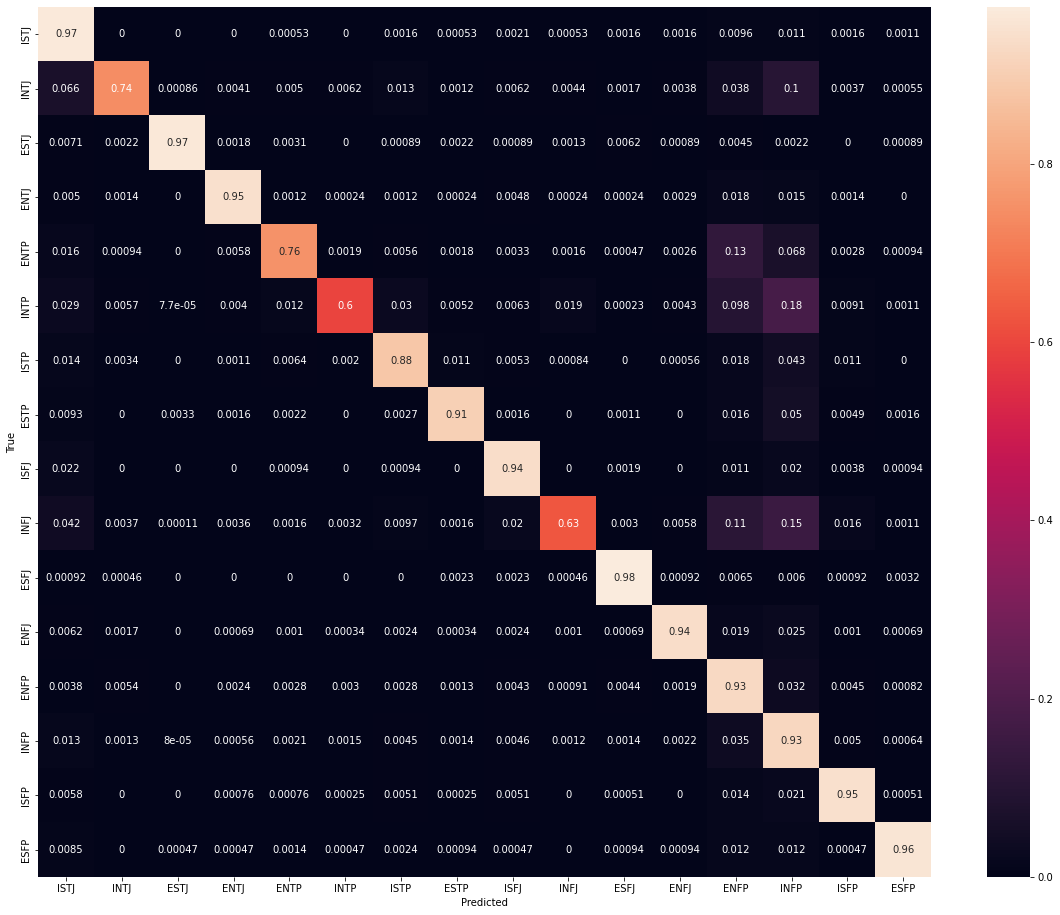

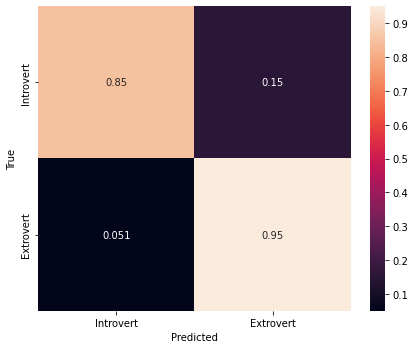

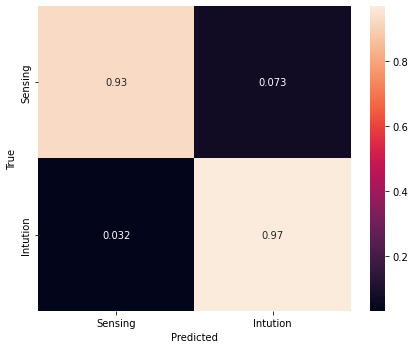

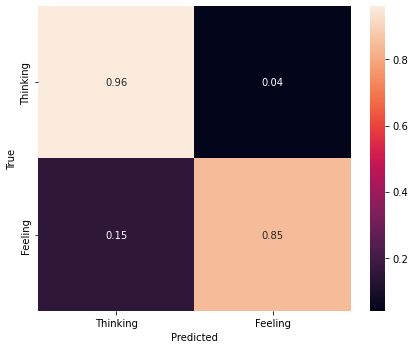

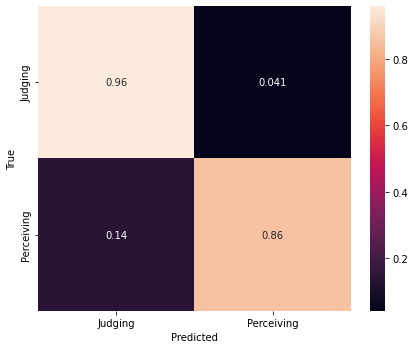

In [91]:
document_multimodel_run('mbti_bert_mh_bin_model',
                   mbti_bert_mh_bin_model,
                   valid_MBTI,ie,si,thinkfeel,jp,results_dict,
                   test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask,
                   nptest_labels,labels_ie,labels_si,labels_tf,labels_jp)

# Multihead attention model no CNN

In [53]:
# # this one is based on the multiheaded attention added 
# def create_mbti_bert_mh_model(bert_model,
#                                 hidden_size = 501, 
#                                 dropout=0.3,
#                                 learning_rate=0.00005,max_length=750):
#     """
#     Build a simple classification model with BERT. Add self attention layers on top of BERT output , training entire BERT is costly
#     """

#     input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
#     attention_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
#     token_type_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids')
  
#     bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
#     sequence_output = bert_output.last_hidden_state

#     #attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=100)(sequence_output, sequence_output)
#     #Fix 1 increasing key dim to match the max length  
#     attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=250)(sequence_output, sequence_output)
#     max_pool = layers.GlobalMaxPooling1D()(attn_output)
#     dropout_output = layers.Dropout(0.3)(max_pool)
#     final_output = layers.Dense(16, activation="softmax")(dropout_output)
    
#     model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
#                                   outputs=[final_output])
#     model.compile(optimizer=tf.keras.optimizers.Adam(),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

In [54]:
# mbti_bert_mh_model = create_mbti_bert_mh_model(bert_model)

In [55]:
# mbti_bert_mh_model.summary()

In [56]:
# keras.utils.plot_model(mbti_bert_mh_model, show_shapes=True, dpi=90)

In [57]:
# mbti_bert_mh_model_history = mbti_bert_mh_model.fit(train_data_generator,    
#                                                   validation_data=dev_data_generator,    
#                                                   callbacks=[model_checkpoint_callback],
#                                                   epochs=4)

In [58]:
# mbti_bert_mh_model_history = mbti_bert_mh_model.fit(train_data_generator,    
#                                                   validation_data=([dev_encodings.input_ids,dev_encodings.token_type_ids, dev_encodings.attention_mask],npdev_labels),    
#                                                   callbacks=[model_checkpoint_callback],
#                                                   epochs=1)

In [59]:
# document_model_run('mbti_bert_mh_model',
#                    mbti_bert_mh_model,
#                    valid_MBTI,results_dict,
#                    test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask,
#                    nptest_labels)

In [60]:

# results_filepath = checkpoint_dir + 'bert_mh_results_1113.txt'
# f = open(results_filepath,"w")

# # write file
# f.write( str(results_dict) )

# # close file
# f.close()

# Lots of testing code do not delete focus on this for tuning

In [61]:
  predictions = mbti_bert_mh_model.predict([test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask])

  predictions = tf.argmax(predictions, axis=-1)

  predictions = predictions.numpy()

NameError: ignored

In [ ]:
test_combined[test_combined['truth']==test_combined['prediction']].count()

In [ ]:
test_combined['messagelength'] = test_combined['message'].str.split().apply(len)

In [ ]:
testlen = test_combined.iloc[0]['message']

In [ ]:
len(testlen.split())

In [ ]:
test_combined['message'].str.split().apply(len).value_counts()

In [ ]:
test_combined

In [ ]:
test_combined['accurate'] = test_combined['truth']== test_combined['prediction']

In [ ]:
gender_df= test_combined[['Gender','truth','accurate']]

In [ ]:
test_combined.Occupation.value_counts()

In [ ]:
test_combined.groupby('Occupation')['accurate'].value_counts().plot(kind='barh')

In [ ]:
test_combined

In [ ]:
empty_emotions = test_combined[test_combined['emotions'] == ""]

In [ ]:
empty_emotions_true = test_combined[test_combined['emotions'] == "" & test_combined['truth'] == test_combined['prediction']]

In [ ]:
test_combined[test_combined['postags'] == ""]['message']

In [ ]:
empty_emotions.iloc[1]

In [ ]:
test_combined.count()

In [ ]:
test_combined.groupby(['postags', 'accurate'])['accurate'].count().unstack()

In [ ]:
test_combined.groupby(['lexicon', 'accurate'])['accurate'].count().unstack()

In [ ]:
test_combined.groupby(['emotions', 'accurate'])['accurate'].count().unstack()

In [ ]:
#this is correct implementation
test_combined.groupby(['Age', 'accurate'])['accurate'].count().unstack()

In [ ]:
#this is screwed up dont run this
# test_combined['Username'] ='julius_van_der_beak'

In [ ]:
test_combined.groupby(['Username', 'accurate'])['accurate'].count().unstack()

In [ ]:
test_combined.groupby(['Username', 'accurate','MBTI Type'])['accurate'].count().unstack()

In [ ]:
test_combined.groupby(['Age', 'accurate','MBTI Type'])['accurate'].count().unstack()

In [ ]:
test_combined.groupby(['Age', 'accurate','MBTI Type'])['truth'].sum().unstack()

In [ ]:
test_combined.groupby(['Occupation', 'accurate'])['truth'].sum().unstack()

In [ ]:
test_combined.groupby(['Occupation', 'accurate'])['truth'].sum().unstack().plot()

In [ ]:
#df.groupby('product')['sales'].plot(legend=True)
gender_df.groupby('Gender')['accurate'].value_counts().plot(kind='bar')

In [ ]:
test_combined.hist(column='Age',by='accurate',bins=100,figsize=(15, 15))

In [ ]:
test_combined.hist(column='messagelength',by='accurate',bins=100,figsize=(15, 15))

In [ ]:
test_combined['stopwords'] = test_combined['message'].str.split().apply(pct_stopwords).value_counts()

In [ ]:
test_combined['prediction'] = predictions.tolist()

In [ ]:
test_combined['truth'] = test_combined['MBTI Type'].map(valid_MBTI).values.tolist()

In [ ]:
correct ={}
wrong={}
correct['mbti_bert_mh_model'] = np.where(nptest_labels == predictions)
wrong['mbti_bert_mh_model'] = np.where(nptest_labels != predictions)

In [ ]:
print('mean',np.mean([len(test_data_st[i].split()) for i in correct['mbti_bert_mh_model'][0]]))
print('min',np.min([len(test_data_st[i].split()) for i in correct['mbti_bert_mh_model'][0]]))
print('max',np.max([len(test_data_st[i].split()) for i in correct['mbti_bert_mh_model'][0]]))

In [ ]:
print('mean',np.mean([len(test_data_st[i].split()) for i in wrong['mbti_bert_mh_model'][0]]))
print('min',np.min([len(test_data_st[i].split()) for i in wrong['mbti_bert_mh_model'][0]]))
print('max',np.max([len(test_data_st[i].split()) for i in wrong['mbti_bert_mh_model'][0]]))

In [ ]:
wrong_guesses = [i for i in np.squeeze(wrong['mbti_bert_mh_model'][0])]

In [ ]:
correct_guesses = [i for i in np.squeeze(correct['mbti_bert_mh_model'][0])]

In [ ]:
stops = {'a', 'the', 'an', 'one', 'these', 'those', 'this', 'that',
         'is', 'was', 'are', 'were'}

def pct_stopwords(text):
    toks = re.findall('\w+', text.lower())
    #b and a / b or 0
    return len(toks) and 100 * len([tok for tok in toks if tok in stops]) / len(toks) or 0

#pct_stopwords('This is a sentence with some stopwords in it.')


In [ ]:
for i in correct_guesses[:10]:
  #print("Combined Mess",test_mbti_data['combined'].values[i])
  #print("label type",test_mbti_labels['MBTI Type'].values[i])
  #print("Total Length",len(test_mbti_data['message'].values[i]))
  print("Stop Words",pct_stopwords(test_mbti_data['message'].values[i]))

In [ ]:
len(correct_guesses)

In [ ]:
tot = 0
for i in correct_guesses:
  tot = tot + pct_stopwords(test_mbti_data['message'].values[i])
print ("avg stop words in correct ", tot/412)

In [ ]:
tot = 0
for i in wrong_guesses:
  tot = tot + pct_stopwords(test_mbti_data['message'].values[i])
print ("avg stop words in wrong ", tot/412)

In [ ]:
# for i in wrong_guesses:
#   #print("Combined Mess",test_mbti_data['combined'].values[i])
#   #print("label type",test_mbti_labels['MBTI Type'].values[i])
#   #print("Total Length",len(test_mbti_data['message'].values[i]))
#   print("Total Words",len(test_mbti_data['message'].values[i]))
#   print("Stop Words",pct_stopwords(test_mbti_data['message'].values[i]))

In [ ]:
stops = {'a', 'the', 'an', 'one', 'these', 'those', 'this', 'that',
         'is', 'was', 'are', 'were'}

def pct_stopwords(text):
    toks = re.findall('\w+', text.lower())
    return 100 * len([tok for tok in toks if tok in stops]) / len(toks)

pct_stopwords('This is a sentence with some stopwords in it.')


In [ ]:
print('mean',np.mean([len(test_data_st[i].split()) for i in correct['mbti_bert_train_cnn_model'][0]]))
print('min',np.min([len(test_data_st[i].split()) for i in correct['mbti_bert_train_cnn_model'][0]]))
print('max',np.max([len(test_data_st[i].split()) for i in correct['mbti_bert_train_cnn_model'][0]]))

In [ ]:
print('mean',np.mean([len(test_data_st[i].split()) for i in wrong['mbti_bert_train_cnn_model'][0]]))
print('min',np.min([len(test_data_st[i].split()) for i in wrong['mbti_bert_train_cnn_model'][0]]))
print('max',np.max([len(test_data_st[i].split()) for i in wrong['mbti_bert_train_cnn_model'][0]]))

In [ ]:
len(test_data_st[100].split())

In [ ]:
pd.Series(predictions).value_counts().plot(kind = 'bar')

In [ ]:
pd.Series(nptest_labels).value_counts().plot(kind = 'bar')

# Notes and Next Steps


#update from 1120
Better results on pushing user profile data into BERT

Follow ups 
a) figure out how to find which results are coming wrong , focus on the testing section
b) plot those 
c) also run the same model, without actually passing the message and does the result degrade 
d) look at notes to self in Slack

